In [13]:
import numpy as np
import pandas as pd
import sys

sys.path.insert(1, '../../../scripts/')
from s3_support import *
%matplotlib inline

# Load data

In [14]:
# load data
q = '''select
            org,
            date_trunc('month', date) as month,
            count(distinct form) as forms,
            count(id) as count,
            sum(amount) as volume
        from transactions
            where status='A'
            group by org, date_trunc('month', date)'''
df = redshift_query_read(q)

# Compute means and standard deviations

In [15]:
meta_data = []
org_data = []

for org in df['org'].unique():
    _df = df[df['org']==org].copy()
    _df.sort_values('month', ascending=True, inplace=True)
    _df = _df[_df['volume']>0]
    
    meta_data.append({
        "org": org,
        "len": len(_df)
    })
    
    _df['cat_month'] = _df['month'].dt.month
    _df['count_growth'] = _df['count'].diff() / _df['count'].shift()
    _df['volume_growth'] = _df['volume'].diff() / _df['volume'].shift()
    _df['forms_growth'] = _df['forms'].diff() / _df['forms'].shift()
    
    grpd = _df.groupby('cat_month')[['count_growth', 'volume_growth', 'forms_growth']].agg(['std', 'mean'])
    grpd['org'] = org
    
    org_data.append(grpd)

In [16]:
df_meta = pd.DataFrame(meta_data)

for i in [0, 3, 6, 12, 24, 36]:
    seg_len = len(df_meta[df_meta['len']>i])
    seg_perc = (float(seg_len) / float(len(df_meta))) * 100.
    
    print("Orgs with greater than {} entries: {} ({:.2f}%)".format(i, seg_len, seg_perc))

Orgs with greater than 0 entries: 5136 (99.53%)
Orgs with greater than 3 entries: 3909 (75.76%)
Orgs with greater than 6 entries: 3336 (64.65%)
Orgs with greater than 12 entries: 2682 (51.98%)
Orgs with greater than 24 entries: 1885 (36.53%)
Orgs with greater than 36 entries: 1374 (26.63%)


In [17]:
org_data[0]

count_growth            volume_growth            forms_growth  \
                   std       mean           std       mean          std   
cat_month                                                                 
1             0.353553  -0.250000      0.352090  -0.748966     0.353553   
2             0.586302   0.125000     15.158839   6.110000     0.516398   
3             0.763763   0.166667     21.785448  22.119351     0.288675   
4             3.621886   2.291667     28.313904  23.150200     0.500000   
5             4.661488   1.504902     10.441884   4.187341     0.487950   
6             0.237745  -0.570055      0.119688  -0.875882     0.288675   
7             1.414214   1.000000     11.476887   8.115385     0.000000   
8            16.733319   7.190476     15.248771   9.136781     0.786796   
9            17.483855  10.222222    153.660096  77.016850     0.527046   
10            1.164027   0.006735      0.895330  -0.245992     0.596285   
11            0.539993  -0.367288      2.155577   0.725976     0.698638   
12            1.451053   0.433333      8.386751   5.433638     0.651920   

                     org  
               mean       
cat_month                 
1         -0.250000  432  
2          0.333333  432  
3         -0.333333  432  
4          0.250000  432  
5          0.285714  432  
6         -0.250000  432  
7          0.000000  432  
8          0.571429  432  
9         -0.166667  432  
10         0.066667  432  
11         0.285714  432  
12        -0.100000  432

# Testing

limiting testing to orgs with > 36 months in order to average the 2 years of data and compute the average percentage error on the following years. this will give at least 1 full years worth of test error.

## Simple mean projection

In [18]:
test_orgs = df_meta[df_meta['len']>36]['org'].tolist()

In [19]:
test_org_data = []
train_org_data = []

for org in test_orgs:
    # isolate this org's data
    _df = df[df['org']==org].copy()
    _df.sort_values('month', ascending=True, inplace=True)
    _df = _df[_df['volume']>0]
    
    # compute month over month growth
    _df['cat_month'] = _df['month'].dt.month
    _df['count_growth'] = _df['count'].diff() / _df['count'].shift()
    _df['volume_growth'] = _df['volume'].diff() / _df['volume'].shift()
    _df['forms_growth'] = _df['forms'].diff() / _df['forms'].shift()
    
    # train/test split at 24 months
    test_org_data.append(_df.iloc[24:])
    _df = _df.head(24)
    
    # mean & std of monthly growth
    grpd = _df.groupby('cat_month')[['count_growth', 'volume_growth', 'forms_growth']].agg(['std', 'mean'])
    grpd['org'] = org
    
    train_org_data.append(grpd)

In [20]:
print("mean test entry per org: {:.0f}".format(np.mean([len(e) for e in test_org_data])))

mean test entry per org: 46


In [21]:
test_results = []
len_error = 0
for org in test_orgs:
    # get parameters and test data
    params = [e for e in train_org_data if e['org'].iloc[0]==org][0]
    test_data = [e for e in test_org_data if e['org'].iloc[0]==org][0]
    
    # iterate through test data and compute percentage errors
    try:
        test_data['projected_vol_growth'] = test_data['cat_month'].apply(lambda x: params['volume_growth']['mean'][x])
        test_data['projection_error'] = (test_data['volume_growth'] - test_data['projected_vol_growth']) * 100.

        test_results.append({
            'org': org,
            'test_samples': len(test_data),
            'mae': test_data['projection_error'].abs().mean(),
            'mse': test_data['projection_error'].pow(2).mean()
        })
    except:
        len_error = len_error + 1

In [22]:
print("{} test results; {} errors".format(len(test_results), len_error))

1266 test results; 108 errors


In [23]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

df_test_results = pd.DataFrame(test_results)
df_test_results[['mae', 'mse', 'test_samples']].mean()

mae                  4124.2795
mse            9295637327.7427
test_samples           46.6493
dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


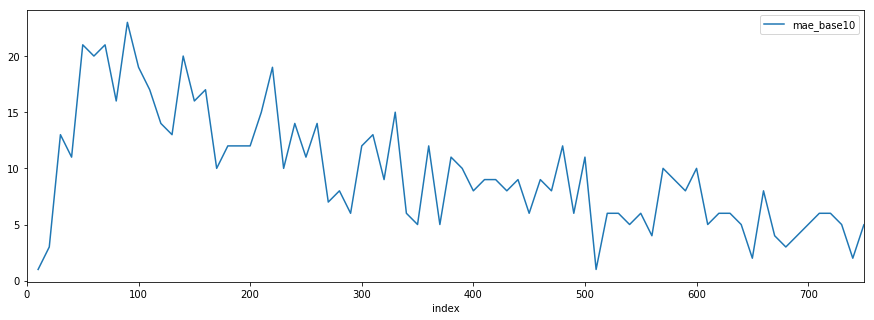

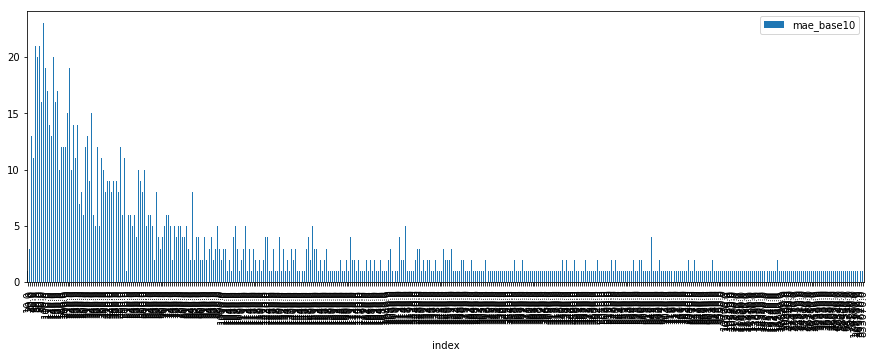

In [24]:
df_test_results['mae_base10'] = df_test_results['mae'].round(-1)
print(df_test_results['mae_base10'].value_counts().reset_index().sort_values("index").plot(x="index", figsize=(15,5), xlim=(0,750)))
print(df_test_results['mae_base10'].value_counts().reset_index().sort_values("index").plot(x="index", kind="bar", figsize=(15,5), xlim=(0,750)))

In [25]:
error_rates = [15., 25., 50., 100., 250., 500., 1000., 2500.]
len_test_results = float(len(df_test_results))

for er in error_rates:
    len_this_error_rate = float(len(df_test_results[df_test_results['mae']<er]))
    mean_test_samples = df_test_results[df_test_results['mae']<er]['test_samples'].mean()
    print("< {}% error: {} orgs ({:.2f}%; {:.2f} samples)".format(int(er), int(len_this_error_rate), (len_this_error_rate / len_test_results) * 100., mean_test_samples))

< 15% error: 1 orgs (0.08%; 60.00 samples)
< 25% error: 4 orgs (0.32%; 51.00 samples)
< 50% error: 43 orgs (3.40%; 51.35 samples)
< 100% error: 139 orgs (10.98%; 49.95 samples)
< 250% error: 356 orgs (28.12%; 48.21 samples)
< 500% error: 586 orgs (46.29%; 47.56 samples)
< 1000% error: 812 orgs (64.14%; 47.17 samples)
< 2500% error: 1030 orgs (81.36%; 46.96 samples)


## Random forest

In [26]:
test_orgs = df_meta[df_meta['len']>36]['org'].tolist()

In [27]:
test_org_data = []
train_org_data = []

for org in test_orgs:
    # isolate this org's data
    _df = df[df['org']==org].copy()
    _df.sort_values('month', ascending=True, inplace=True)
    _df = _df[_df['volume']>0]
    
    # compute month over month growth
    _df['cat_month'] = _df['month'].dt.month
    _df['count_growth'] = _df['count'].diff() / _df['count'].shift()
    _df['volume_growth'] = _df['volume'].diff() / _df['volume'].shift()
    _df['forms_growth'] = _df['forms'].diff() / _df['forms'].shift()
    
    # train/test split at 24 months
    test_org_data.append(_df.iloc[24:])
    _df = _df.head(24)
    
    # mean & std of monthly growth
    grpd = _df.groupby('cat_month')[['count_growth', 'volume_growth', 'forms_growth']].mean().reset_index()
    grpd['org'] = org
    
    train_org_data.append(grpd)

In [28]:
train_org_growth_df = None
for d in train_org_data:
    if train_org_growth_df is None:
        train_org_growth_df = d
    else:
        train_org_growth_df = train_org_growth_df.append(d)

In [29]:
len(train_org_growth_df), len(train_org_growth_df['org'].unique())

(16297, 1374)

In [30]:
train_org_growth_df.head()

,cat_month,count_growth,volume_growth,forms_growth,org
0,1,-0.5000,-0.5000,-0.5000,432
1,2,0.0000,-0.9500,0.0000,432
2,3,1.0000,24.0000,0.0000,432
3,4,4.7500,17.3000,0.5000,432
4,5,-0.7386,0.1106,0.0000,432


# Grouping by volatility

I suspect the reason we are seeing such abysmal accuracy rates is due to the wildly differing performance consistency across organizations. It may be helpful to categorize the organizations by processing consistency so that we may independently model organizations by their volatility profiles.

In [31]:
test_orgs = df_meta[df_meta['len']>24]['org'].tolist()

In [32]:
test_org_data = []
train_org_data = []

for org in test_orgs:
    # isolate this org's data
    _df = df[df['org']==org].copy()
    _df.sort_values('month', ascending=True, inplace=True)
    _df = _df[_df['volume']>0]
    
    # compute month over month growth
    _df['cat_month'] = _df['month'].dt.month
    _df['count_growth'] = _df['count'].diff() / _df['count'].shift()
    _df['volume_growth'] = _df['volume'].diff() / _df['volume'].shift()
    _df['forms_growth'] = _df['forms'].diff() / _df['forms'].shift()
    
    # mean & std of monthly growth
    grpd = _df.groupby('cat_month')[['count_growth', 'volume_growth', 'forms_growth']].agg(['std', 'mean'])
    grpd['org'] = org
    
    train_org_data.append(grpd)

In [33]:
agg_data = None
for o in train_org_data:
    test_df = o.reset_index()
    test_df.columns = test_df.columns.map("-".join)
    test_df.columns = [col.replace('_growth', '').strip('-') for col in test_df.columns]
    
    if agg_data is None:
        agg_data = test_df
    else:
        agg_data = agg_data.append(test_df)

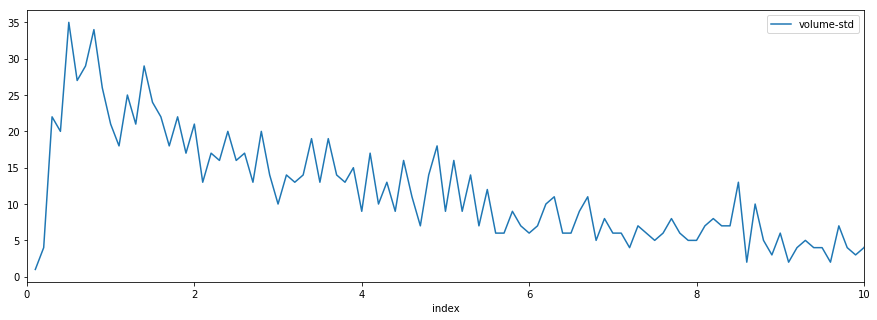

In [34]:
agg_data.groupby('org')['volume-std'].mean().round(decimals=1).value_counts().reset_index().sort_values('index').plot(x='index', y='volume-std', xlim=(0,10), figsize=(15,5))

In [35]:
vol_stds = agg_data.groupby('org')['volume-std'].mean().reset_index()
for i in [1., 2., 5., 10., 50.]:
    this_len = len(vol_stds[vol_stds['volume-std']<=i])
    this_perc = (float(this_len) / float(len(vol_stds))) * 100.
    print("{} orgs ({:.2f}%) with std less than {}".format(this_len, this_perc, i))

211 orgs (11.19%) with std less than 1.0
428 orgs (22.71%) with std less than 2.0
855 orgs (45.36%) with std less than 5.0
1192 orgs (63.24%) with std less than 10.0
1662 orgs (88.17%) with std less than 50.0


Now we will segment the trials by these groups in order to determine if we can increase our accuracy by focusing on a given subset by performance variance.

In [36]:
std_segments = [
    (0., 1.),
    (1., 2.),
    (2., 5.),
    (5., 10.),
    (10., 50.)
]

In [39]:
for segment in std_segments:
    these_orgs = vol_stds[(vol_stds['volume-std']>=segment[0])&(vol_stds['volume-std']<segment[1])]['org'].tolist()
    
    print("-"*40)
    print("Volatility segment {}; {} orgs".format(segment, len(these_orgs)))
    print(df_test_results[df_test_results['org'].isin(these_orgs)][['mae', 'mse', 'test_samples']].mean())

----------------------------------------
Volatility segment (0.0, 1.0); 211 orgs
mae               71.0770
mse            16396.6392
test_samples      49.4295
dtype: float64
----------------------------------------
Volatility segment (1.0, 2.0); 217 orgs
mae               167.5969
mse            109480.8210
test_samples       46.7391
dtype: float64
----------------------------------------
Volatility segment (2.0, 5.0); 427 orgs
mae               394.2902
mse            832306.1648
test_samples       46.4188
dtype: float64
----------------------------------------
Volatility segment (5.0, 10.0); 337 orgs
mae                822.6977
mse            4953670.4733
test_samples        48.8084
dtype: float64
----------------------------------------
Volatility segment (10.0, 50.0); 470 orgs
mae                2686.2019
mse            91253031.2895
test_samples         45.3541
dtype: float64


It looks like with lower standard deviation segments we see lower error rates, which is what we expected. However, the best case (lowest STD) results in an absolute test error of 71%. This is still not good enough to deliver as a prediction and it only covers about 11% of the organizations. 